# Tiles generation

## Importing

In [1]:
import json
from google_drive_downloader import GoogleDriveDownloader as gdd
import shutil, os
from ops import load_opt, load_sar, generate_save_patches, min_max_scaler
import numpy as np
import logging
from PIL import Image
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

## Setting parameters

In [2]:
#load the params-patches.json options
with open(os.path.join('v1', 'params-patches.json')) as param_file:
    params_patches = json.load(param_file)

#load the params-models.json options
with open(os.path.join('v1', 'params-model.json')) as param_file:
    params_model = json.load(param_file)
    
#load the params-patches.json options
with open(os.path.join('v1', 'params-download.json')) as param_file:
    params_download = json.load(param_file)

In [3]:
img_path = params_patches['img_path']
opt_raw = os.path.join(img_path, params_patches['opt_sub'])
sar_raw = os.path.join(img_path, params_patches['sar_sub'])
label_raw = os.path.join(img_path, params_patches['label_sub'])

tiles_patch = params_patches['tiles_patch']

## Download files, if necessary

In [4]:
if params_patches['download']:
    shutil.rmtree(img_path, ignore_errors=True)
    os.makedirs(opt_raw)
    os.makedirs(sar_raw)
    os.makedirs(label_raw)

    #download and save OPT files
    for f in params_download['files_opt']:
        gdd.download_file_from_google_drive(file_id=f['id'],
                                        dest_path=os.path.join(opt_raw, f['name']))

    #download and save SAR files
    for f in params_download['files_sar']:
        gdd.download_file_from_google_drive(file_id=f['id'],
                                        dest_path=os.path.join(sar_raw, f['name']))

    #download and save LABELS files
    for f in params_download['files_labels']:
        gdd.download_file_from_google_drive(file_id=f['id'],
                                        dest_path=os.path.join(label_raw, f['name']))



## Labels

In [5]:
shutil.rmtree(tiles_patch, ignore_errors=True)
os.makedirs(tiles_patch)
labels = np.expand_dims(np.load(os.path.join(label_raw, 'labels.npy')), axis=-1)

In [6]:
h_split = np.array_split(labels, params_patches['tiles_v'], axis=0)
tiles = []
for part in h_split:
    v_split = np.array_split(part, params_patches['tiles_h'], axis=1)
    for tile in v_split:
        tiles.append(tile)

for idx, tile in enumerate(tiles):
    np.save(os.path.join(tiles_patch, f'{idx+1:02d}.npy'), tile)

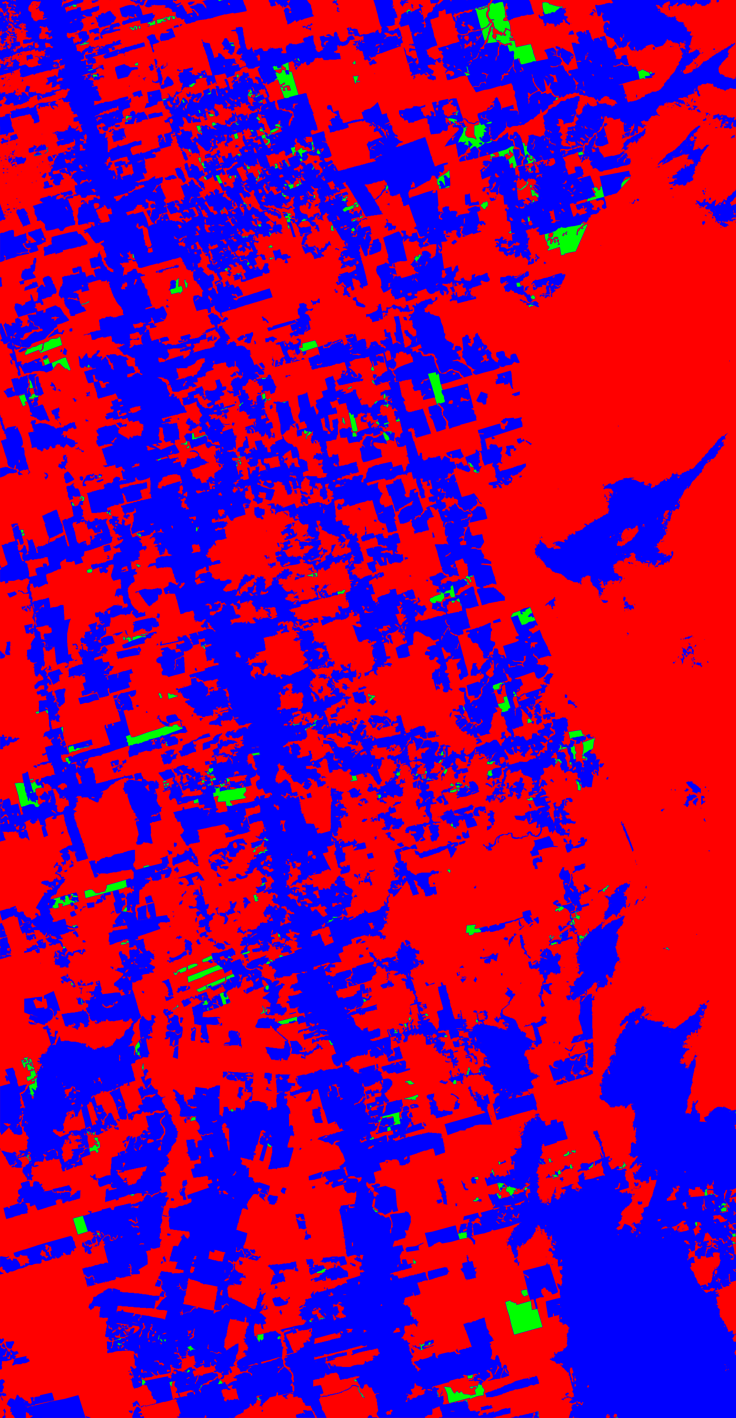

In [7]:
categorical = to_categorical(labels, params_model['classes'])
img = Image.fromarray(np.uint8(categorical*255))
resize = 0.08
shape = (int(resize*categorical.shape[1]), int(resize*categorical.shape[0]))
img.resize(shape)

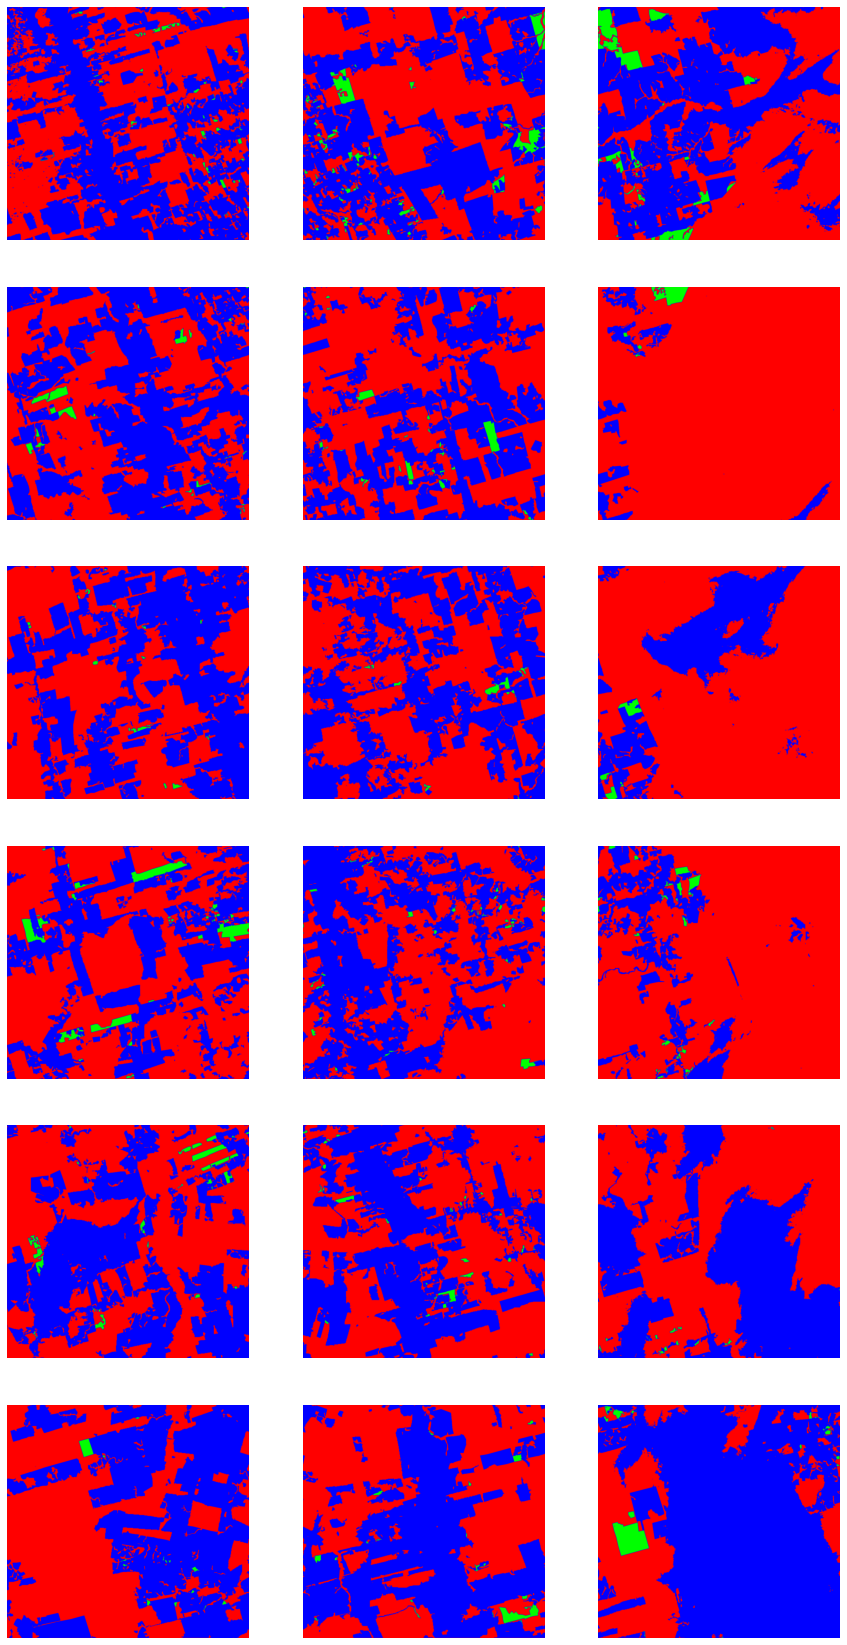

In [16]:
fig, ax = plt.subplots(nrows=params_patches['tiles_v'], ncols=params_patches['tiles_h'], figsize = (15,30))

for row_idx, row in enumerate(ax):
    for col_idx, col in enumerate(row):
        tile_idx = row_idx*params_patches['tiles_h'] + col_idx
        categorical = to_categorical(tiles[tile_idx], params_model['classes'])
        img = Image.fromarray(np.uint8(categorical*255))
        col.axis('off')
        col.set_xticklabels([])
        col.imshow(img)

In [17]:
del labels, tiles

## Optical images